In [1]:
# add the parent directory to the system path:
import sys
from pathlib import Path
parent_dir = Path('..').resolve() 
sys.path.append(str(parent_dir)) 

# import:
import sympy
import argparse
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import equations
import data
from derivative import dxdt
from gplearn.genetic import SymbolicRegressor
from utils import generator
import functools
from scipy.stats import ks_2samp

In [2]:
def trjectories(ode_name, ode_param, x_id, freq, n_sample, noise_ratio, alg, seed, n_seed):
    
    # seed:
    np.random.seed(999)

    # upload the results:
    seed_s = seed
    seed_e = n_seed
    if alg == 'diff':
        path_base = '../results/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
    else: # -> alg == 'vi':
        path_base = '../results_vi/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
    
    res_list = []
    for s in range(seed_s, seed_e):
        if x_id == 0:
            path = path_base + 'grad_seed_{}.pkl'.format(s)
        else:
            path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

        try:
            with open(path, 'rb') as f:
                res = pickle.load(f)
            res_list.append(res)
        except Exception:
            pass
    print(len(res_list)) # check

    # percentage of correct identifications:
    correct_list = [res['correct'] for res in res_list] # list of booleans: 1 if the model has correctly identified the ODE, 0 otherwise
    p_correct = np.mean(correct_list) # percentage of correct identifications
    std_correct = np.sqrt(p_correct * (1 - p_correct) / len(correct_list)) # standard deviation of the percentage of correct identifications
    print(p_correct)

    # estimated trajectories:
    ode = equations.get_ode(ode_name, ode_param)
    est_trjectories = []
    for res in res_list:

        ode_true = res['ode']
        dim_x = ode_true.dim_x
        f_hat_partial = res['model'].execute 

        def f_hat(t, X):
            
            x = X[0]
            y = X[1]
            rho = X[2]
            X = np.reshape(X, (1, 3))

            dxdt = f_hat_partial(X)
            dxdt = dxdt.item()
            [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() 
            
            return [dxdt, dydt, drdt]
        
        dg_hat = data.DataGenerator_p(f_hat, dim_x, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
        xt_hat = dg_hat.xt

        est_trjectories.append(xt_hat)
    return est_trjectories
    

In [3]:
# select the ODE:
ode_name = 'SelkovODE_rho_09'
ode_param=None
x_id = 0
freq = 10
n_sample = 50 
noise_ratio = 0.01
alg = 'diff'
seed = 0
n_seed = 5

In [4]:
# true trajectory:
ode = equations.get_ode(ode_name, ode_param)
dg_true = data.DataGenerator(ode, ode.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
xt_true = dg_true.xt
print(np.shape(xt_true))

# estimated trajectories:
est_trjectories = trjectories(ode_name, ode_param, x_id, freq, n_sample, noise_ratio, alg, seed, n_seed)
print(np.shape(est_trjectories))

(151, 1, 3)
5
0.6
(5, 151, 1, 3)


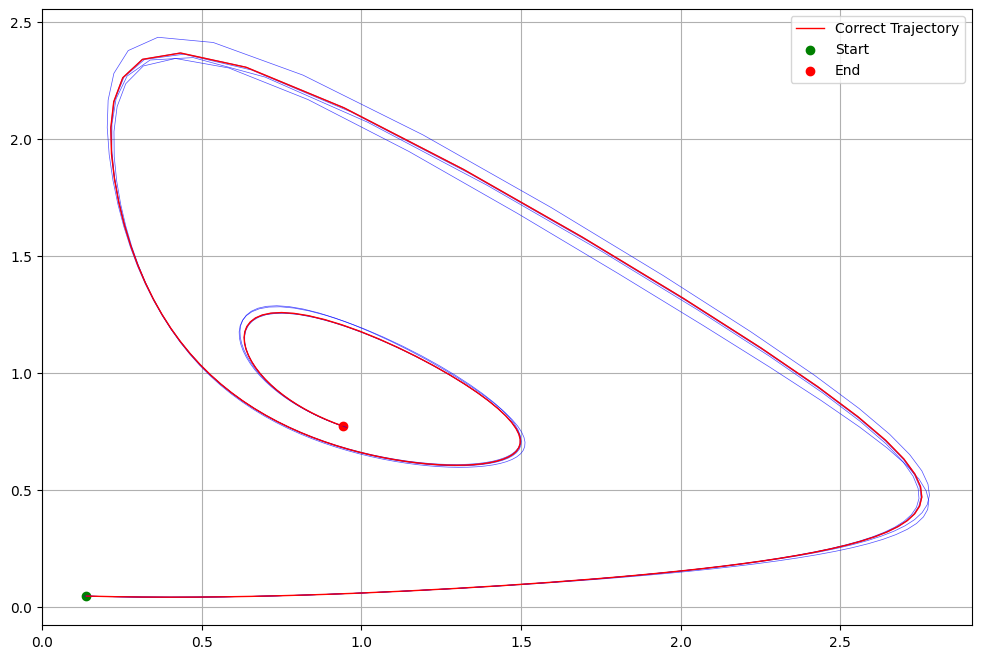

In [12]:
# plot:
plt.figure(figsize=(12, 8))

for i in range(np.shape(est_trjectories)[0]):
    plt.plot(est_trjectories[i][:, 0, 0], est_trjectories[i][:, 0, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(xt_true[:, 0, 0], xt_true[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')


plt.scatter(xt_true[:, 0, 0][0], xt_true[:, 0, 1][0], color='green', label='Start')
plt.scatter(xt_true[:, 0, 0][-1], xt_true[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True) 


In [5]:
# seed:
np.random.seed(999)

# select the ODE:

ode_name = 'SelkovODE_rho_09'
ode_param=None
ode = equations.get_ode(ode_name, ode_param)
x_id = 0
freq = 10
n_sample = 50 
noise_ratio = 0.01
alg = 'diff'
seed = 0
n_seed = 5
eval_state = True

In [6]:
# upload the results:

if alg == 'diff':
    path_base = '../results/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
elif alg == 'vi':
    path_base = '../results_vi/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
elif alg == 'spline':
    path_base = '../results_spline/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
elif alg == 'gp':
    path_base = '../results_gp/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
elif alg == 'node':
    path_base = '../results_node/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)
else:
    path_base = '../results_node_one_step/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_ratio, n_sample, freq)

seed_s = seed
seed_e = n_seed
res_list = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list.append(res)
    except Exception:
        pass

len(res_list)

5

In [7]:
# true trajectories:
dg_true = data.DataGenerator(ode, ode.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
xt_true = dg_true.xt
print(np.shape(xt_true))

# estimated trajectories:
est_trjectories = []
for res in res_list:
    #try:
    ode_true = res['ode']
    dim_x = ode_true.dim_x
    f_hat_partial = res['model'].execute 

    def f_hat(t, X):
        
        x = X[0]
        y = X[1]
        rho = X[2]
        X = np.reshape(X, (1, 3))

        dxdt = f_hat_partial(X)
        dxdt = dxdt.item()
        [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() 
        
        return [dxdt, dydt, drdt]
    
    dg_hat = data.DataGenerator_p(f_hat, dim_x, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
    xt_hat = dg_hat.xt
    #print(np.shape(xt_hat))

    est_trjectories.append(xt_hat)
print(np.shape(est_trjectories))

(151, 1, 3)
(5, 151, 1, 3)


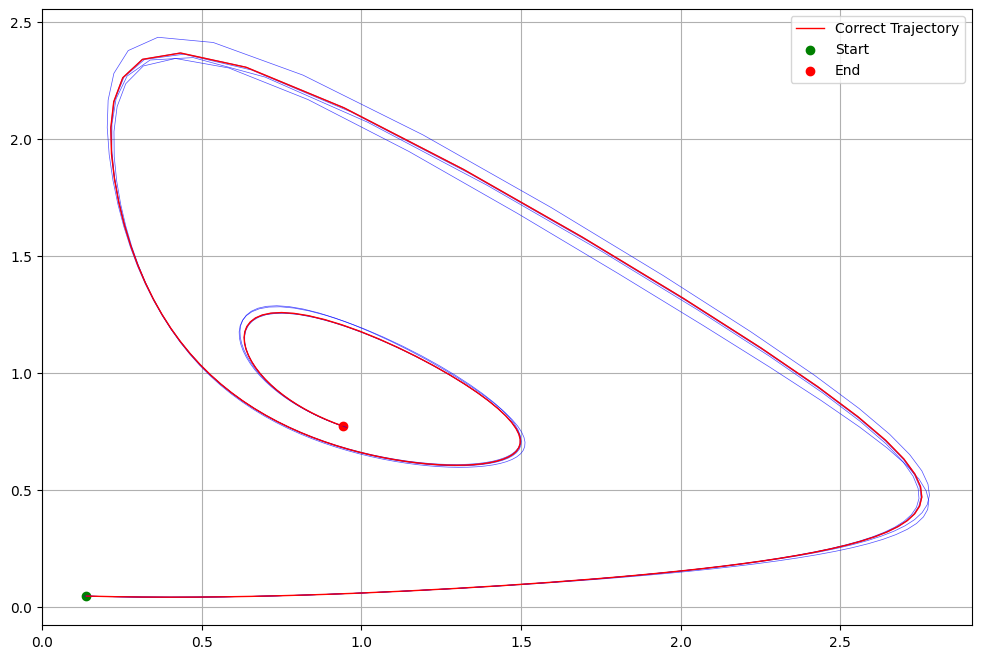

In [10]:
plt.figure(figsize=(12, 8))

for i in range(np.shape(est_trjectories)[0]):
    plt.plot(est_trjectories[i][:, 0, 0], est_trjectories[i][:, 0, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(xt_true[:, 0, 0], xt_true[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')


plt.scatter(xt_true[:, 0, 0][0], xt_true[:, 0, 1][0], color='green', label='Start')
plt.scatter(xt_true[:, 0, 0][-1], xt_true[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

In [4]:
res = res_list[0]

ode_true = res['ode']
f_hat_partial = res['model'].execute 

(151, 1, 3)


In [8]:
def f_hat(t, X):

    # dato un input (3,)
    x = X[0]
    y = X[1]
    rho = X[2]

    # f_hat_partial deve invece avere input di forma (1, 3) -> reshape
    X = np.reshape(X, (1, 3))
    #print(np.shape(X))
    dxdt = f_hat_partial(X)
    dxdt = dxdt.item()
    #print(dxdt)


    [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() # fix it 
    #print(np.shape([dydt, drdt]))

    #print([dxdt, dydt, drdt])
    #print(np.shape([dxdt, dydt, drdt]))
    return [dxdt, dydt, drdt]

In [9]:
# test0
x0 = xt_true[0, :, :]
x0 = np.reshape(x0, (3,))
print(np.shape(x0))
t = 0
dx0 = f_hat(t, x0)

(3,)


In [10]:
# test1
res = res_list[0]

ode_true = res['ode']
f_hat_partial = res['model'].execute 
dim_x = ode_true.dim_x
print(dim_x)

dg_true = data.DataGenerator(ode_true, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=ode_true.init_high, init_low=ode_true.init_low)
xt_true = dg_true.xt
print(np.shape(xt_true))

dg_hat = data.DataGenerator_p(f_hat, dim_x, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=ode_true.init_high, init_low=ode_true.init_low)
xt_hat = dg_hat.xt
print(np.shape(xt_hat))

3
(151, 1, 3)
(151, 1, 3)


In [22]:
print(xt_true[1:10, :, 0])
print(xt_hat[1:10, :, 0])
print(ode_true.init_high)
print(ode_true.init_low)

[[0.21475224]
 [0.30549592]
 [0.39532704]
 [0.48425249]
 [0.57227763]
 [0.65940624]
 [0.74564037]
 [0.83098007]
 [0.91542322]]
[[0.26737619]
 [0.35456416]
 [0.44087655]
 [0.52632011]
 [0.61090025]
 [0.69462075]
 [0.7774835 ]
 [0.85948822]
 [0.94063233]]
[0.1, 0.1, 0.95]
[0, 0, 0.85]


In [23]:
dg_true = data.DataGenerator(ode_true, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
xt_true = dg_true.xt
print(np.shape(xt_true))

dg_hat = data.DataGenerator_p(f_hat, dim_x, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
xt_hat = dg_hat.xt
print(np.shape(xt_hat))



(151, 1, 3)
(151, 1, 3)


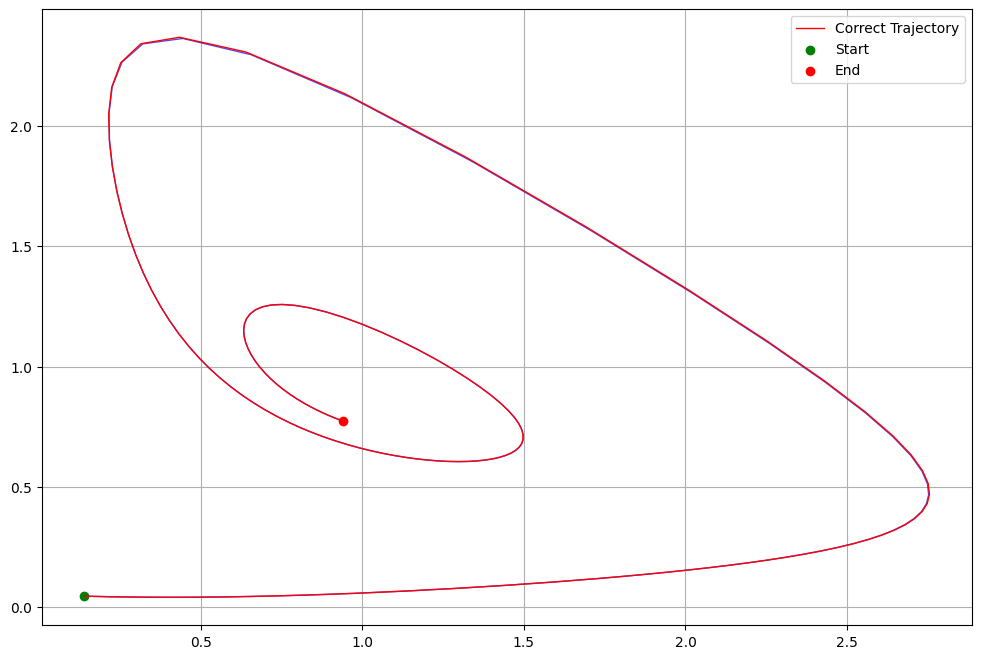

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(xt_hat[:, 0, 0], xt_hat[:, 0, 1], color='blue', linewidth=1.0, alpha=0.7)

plt.plot(xt_true[:, 0, 0], xt_true[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

plt.scatter(xt_true[:, 0, 0][0], xt_true[:, 0, 1][0], color='green', label='Start')
plt.scatter(xt_true[:, 0, 0][-1], xt_true[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

In [6]:

ode_name = 'SelkovODE_rho_09'
ode_param=None
ode = equations.get_ode(ode_name, ode_param)

dg_true = data.DataGenerator(ode, ode.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
xt_true = dg_true.xt
print('xt_true')
print(np.shape(xt_true))

rec_trjectories = []

for res in res_list:
    #try:
    ode_true = res['ode']
    dim_x = ode_true.dim_x
    f_hat_partial = res['model'].execute 

    def f_hat(t, X):
        
        x = X[0]
        y = X[1]
        rho = X[2]
        X = np.reshape(X, (1, 3))

        dxdt = f_hat_partial(X)
        dxdt = dxdt.item()
        [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() 
        
        return [dxdt, dydt, drdt]
    
    dg_hat = data.DataGenerator_p(f_hat, dim_x, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=[0.05, 0.05, 0.9], init_low=[0.05, 0.05, 0.9])
    xt_hat = dg_hat.xt
    print(np.shape(xt_hat))

    rec_trjectories.append(xt_hat)
    print(np.shape(rec_trjectories))
    


xt_true
(151, 1, 3)
(151, 1, 3)
(1, 151, 1, 3)
(151, 1, 3)
(2, 151, 1, 3)
(151, 1, 3)
(3, 151, 1, 3)
(151, 1, 3)
(4, 151, 1, 3)
(151, 1, 3)
(5, 151, 1, 3)


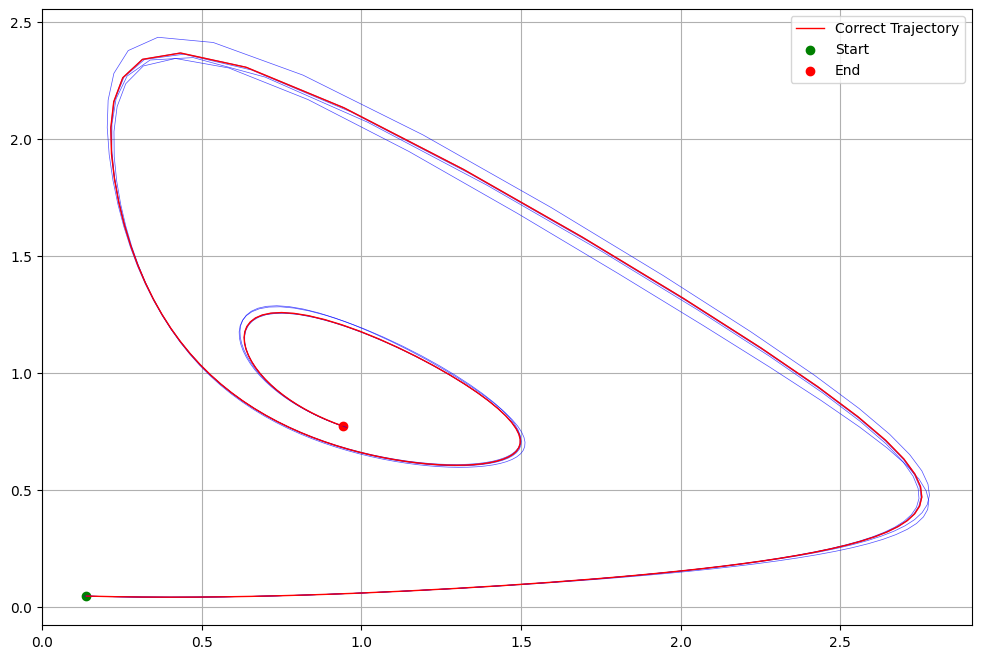

In [8]:
plt.figure(figsize=(12, 8))

for i in range(np.shape(rec_trjectories)[0]):
    plt.plot(rec_trjectories[i][:, 0, 0], rec_trjectories[i][:, 0, 1], color='blue', linewidth=0.5, alpha=0.7)

plt.plot(xt_true[:, 0, 0], xt_true[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')


plt.scatter(xt_true[:, 0, 0][0], xt_true[:, 0, 1][0], color='green', label='Start')
plt.scatter(xt_true[:, 0, 0][-1], xt_true[:, 0, 1][-1], color='red', label='End')


#plt.title(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

In [ ]:
def f_hat(x, y, rho): # add t if needed
    X = np.stack((x, y, rho), axis=-1)
    #print(np.shape(X))
    if np.shape(X)[0] > 1:
        X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
    #print(np.shape(X))

    dxdt = f_hat_partial(X)
    #print(np.shape(dxdt))

    [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() # fix it 
    #print(np.shape([dydt, drdt]))
    
    if np.shape(X)[0] == 1:
        dxdt = dxdt.item()

    #print([dxdt, dydt, drdt])
    #print(np.shape([dxdt, dydt, drdt]))
    return [dxdt, dydt, drdt]

In [8]:
def f_hat(t, X): #def f_hat(x, y, rho):
    
    x = X[0]
    y = X[1]
    rho = X[2]
    
    #X = np.stack((x, y, rho), axis=-1)
    #print(np.shape(X))
    #if np.shape(X)[0] > 1:
    #    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
    #print(np.shape(X))

    dxdt = f_hat_partial(x)
    #print(np.shape(dxdt))

    [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() # fix it 
    #print(np.shape([dydt, drdt]))
    
    if np.shape(X)[0] == 1:
        dxdt = dxdt.item()

    #print([dxdt, dydt, drdt])
    #print(np.shape([dxdt, dydt, drdt]))
    return [dxdt, dydt, drdt]

In [44]:
dxdt_hat = f_hat(xt_true[1:10, :, 0], xt_true[1:10, :, 1], xt_true[1:10, :, 2])
print(np.shape(dxdt_hat))
dx0dt_hat = f_hat(xt_true[0, :, 0], xt_true[0, :, 1], xt_true[0, :, 2])
print(np.shape(dx0dt_hat))

(3, 9)
(3,)


(3,)
(1, 3)
()
(2,)


In [8]:
if eval_state:
        s_list = list()

for res in res_list:
    #try:
    ode_true = res['ode']
    f_hat = res['model'].execute 
    
    dg_true = data.DataGenerator(ode_true, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=ode_true.init_high, init_low=ode_true.init_low)
    xt_true = dg_true.xt
    print('xt_true')
    print(np.shape(xt_true))

    #dg_hat = data.DataGenerator_p(res['model'].execute, ode_true.T, freq=10, n_sample=1, noise_sigma=0., init_high=ode_true.init_high, init_low=ode_true.init_low, x_id=x_id)
    #xt_hat = dg_hat.xt
    #print(np.shape(xt_hat))

    xt_true = xt_true.reshape(xt_true.shape[0] * xt_true.shape[1], xt_true.shape[2])
    print('xt_true')
    print(np.shape(xt_true))

    dxdt_hat = f_hat(xt_true).flatten()
    print('dxdt_hat')
    print(np.shape(dxdt_hat))

    x_in = [xt_true[:, i] for i in range(xt_true.shape[1])]
    print('x_in')
    print(np.shape(x_in))

    dxdt_true = ode_true._dx_dt(*x_in)[x_id]
    print('dxdt_true')
    print(np.shape(dxdt_true))

xt_true
(151, 1, 3)
xt_true
(151, 3)
dxdt_hat
(151,)
x_in
(3, 151)
dxdt_true
(151,)
xt_true
(151, 1, 3)
xt_true
(151, 3)
dxdt_hat
(151,)
x_in
(3, 151)
dxdt_true
(151,)
xt_true
(151, 1, 3)
xt_true
(151, 3)
dxdt_hat
(151,)
x_in
(3, 151)
dxdt_true
(151,)
xt_true
(151, 1, 3)
xt_true
(151, 3)
dxdt_hat
(151,)
x_in
(3, 151)
dxdt_true
(151,)
xt_true
(151, 1, 3)
xt_true
(151, 3)
dxdt_hat
(151,)
x_in
(3, 151)
dxdt_true
(151,)


### Dev:

In [ ]:
def f_hat(t, X):
    
    X = np.reshape(X, (1, 3))

    dxdt = f_hat_1(X)
    dxdt = dxdt.item()
    dydt = f_hat_2(X)
    dydt = dxdt.item()
    drdt = np.zeros_like(dydt)

    return [dxdt, dydt, drdt]

In [ ]:
def f_hat(t, X):
            
    x = X[0]
    y = X[1]
    rho = X[2]
    X = np.reshape(X, (1, 3))

    dxdt = f_hat_partial(X)
    dxdt = dxdt.item()
    _, dydt, drdt = ode_true._dx_dt(x, y, rho)
    dydt = np.asarray(dydt).squeeze()
    drdt = np.asarray(drdt).squeeze()
    
    return [dxdt, dydt, drdt]

In [ ]:
def f_hat(t, X):
            
    x = X[0]
    y = X[1]
    rho = X[2]
    X = np.reshape(X, (1, 3))

    dxdt = f_hat_partial(X)
    dxdt = dxdt.item()
    [dydt, drdt] = np.asarray(ode_true.partial_dx_dt(x, y, rho)).squeeze() 
    
    return [dxdt, dydt, drdt]

In [ ]:
def dx_dt(self, t, x):
        #print(np.shape(x))
        arg_list = list()
        for i in range(self.dim_x):
            arg_list.append(x[i])
        return self._dx_dt(*arg_list)

def _dx_dt(self, x, y, rho):
    dxdt = rho - self.sigma * x - x * y * y
    dydt = -1 * y + self.sigma * x + x * y * y
    drdt = 0 * rho
    #print(np.shape([dxdt, dydt, drdt]))
    return [dxdt, dydt, drdt]

def partial_dx_dt(self, x, y, rho): # per ora lo costruiamo solo per funzionare nel caso x_id=0, poi estenderlo passando anche x_id
        dydt = -1 * y + self.sigma * x + x * y * y
        drdt = 0 * rho
        return [dydt, drdt]

In [5]:
X = np.stack((xt_true[:, :, 0], xt_true[:, :, 1], xt_true[:, :, 2]), axis=-1)
print(np.shape(X))
if len(X.shape) > 2:
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2]) # applico la trasformazione nel solo caso multi-step
print(np.shape(X))

dxdt_hat = f_hat_partial(X)
print(np.shape(dxdt_hat))

X0 = np.stack((xt_true[0, :, 0], xt_true[0, :, 1], xt_true[0, :, 2]), axis=-1)
print(np.shape(X0))
if len(X0.shape) > 2:
    X0 = X0.reshape(X0.shape[0] * X0.shape[1], X0.shape[2]) # applico la trasformazione nel solo caso multi-step
print(np.shape(X0))

dx0dt_hat = f_hat_partial(X0)
print(np.shape(dx0dt_hat))


print('dxdt_hat:', dxdt_hat)
print('dx0dt_hat:', dx0dt_hat)

(151, 1, 3)
(151, 3)
(151,)
(1, 3)
(1, 3)
(1,)
dxdt_hat: [ 0.84486554  0.83625739  0.82774285  0.81930202  0.81091839  0.80257679
  0.79426203  0.78595812  0.77764772  0.76931193  0.76093011  0.75247988
  0.74393701  0.7352754   0.72646694  0.71748136  0.70828598  0.69884541
  0.68912108  0.67907072  0.6686477   0.65780016  0.64647001  0.63459163
  0.62209042  0.60888075  0.59486372  0.57992409  0.56392665  0.54671138
  0.52808748  0.5078257   0.4856477   0.46121292  0.43410102  0.40378752
  0.36961094  0.33072846  0.28605295  0.23416562  0.17318884  0.1006065
  0.0130015  -0.09432411 -0.22790051 -0.39684742 -0.61384215 -0.89602725
 -1.26478632 -1.74089051 -2.32628616 -2.95790015 -3.43985965 -3.46734488
 -2.90664045 -2.03249641 -1.23671604 -0.68156901 -0.33868712 -0.13406707
 -0.00995704  0.06876293  0.12176104  0.15983076  0.18893839  0.21244069
  0.23226805  0.24955478  0.26498059  0.27895937  0.29174614  0.30349911
  0.31431651  0.3242589   0.33336294  0.34165001  0.34913161  0.3558

In [ ]:
# Calcolo percentuale di correttezza
correct_list = [res['correct'] for res in res_list] # list of booleans: 1 if the model has correctly identified the ODE, 0 otherwise
p_correct = np.mean(correct_list) # percentage of correct identifications
#std_correct = np.sqrt(p_correct * (1 - p_correct) / len(correct_list)) # standard deviation of the percentage of correct identifications
print(p_correct)

In [ ]:
# Calcolo del passo di campionamento
dt = 1 / freq
# Generazione del vettore di istanti temporali
time_vector = np.arange(0, ode_true.T + dt, dt)
print(np.shape(time_vector))

In [ ]:

            #rmse = np.sqrt(np.mean((dxdt_hat - dxdt_true) ** 2))
            #s_list.append(rmse)

            # plt.figure(figsize=(12, 8))

            # for i in range(n_sample):
            #     plt.plot(dxdt_hat[:, i, 0], dxdt_hat[:, i, 1], color='blue', linewidth=0.5, alpha=0.7)

            # plt.plot(dxdt_true[:, 0, 0], dxdt_true[:, 0, 1], color='red', linewidth=1.0, label='Correct Trajectory')

            # plt.scatter(dxdt_true[:, 0, 0][0], dxdt_true[:, 0, 1][0], color='green', label='Start')
            # plt.scatter(dxdt_true[:, 0, 0][-1], dxdt_true[:, 0, 1][-1], color='red', label='End')


            # #plt.title(title)
            # #plt.xlabel(xlabel)
            # #plt.ylabel(ylabel)
            # plt.legend()
            # plt.grid(True)


            #except ValueError:
            #    pass

        #s_mean = np.mean(s_list)
        #s_std = np.std(s_list) / np.sqrt(len(res_list))

In [ ]:
np.random.seed(999)
ode_name = 'SelkovODE_rho_04'

ode_param=None
ode_param_1 = [0.40, 0.1]
ode_param_2 = [0.425, 0.1]
ode_param_3 = [0.45, 0.1]

x_id = 0 
freq = 10
n_sample = 10 
noise_ratio = 0.01
seed = 0

# specify ODE:
ode = equations.get_ode(ode_name, ode_param)
ode_1 = equations.get_ode(ode_name, ode_param_1)
ode_2 = equations.get_ode(ode_name, ode_param_2)
ode_3 = equations.get_ode(ode_name, ode_param_3)

T = ode.T
#print(T)
init_low = ode.init_low
#print(init_low)
init_high = ode.init_high
#print(init_high)

noise_sigma = ode.std_base * noise_ratio # RMK. noise_ratio is the standardized level for noise, noise_sigma is specific for the equation at hand
#print(noise_sigma)


In [2]:
def load_results(path_base: Path, x_id: int = 0, seed_s: int = 0, seed_e: int = 1):
    res_list = []
    for s in range(seed_s, seed_e):
        if x_id == 0:
            path = path_base / f"grad_seed_{s}.pkl"
        else:
            path = path_base / f"grad_x_{x_id}_seed_{s}.pkl"

        try:
            with open(path, "rb") as f:
                res = pickle.load(f)
            res_list.append(res)
        except FileNotFoundError:
            pass   
    return res_list


In [3]:
ode_name = "GompertzODE"
noise_sigma = 0.01
n_sample = 50
freq = 10
x_id = 0
seed_s = 0
seed_e = 1

path_base = Path(f"results/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

len(res_list)

1

In [4]:
path_base = Path(f"results_vi/{ode_name}/noise-{noise_sigma}/sample-{n_sample}/freq-{freq}/")

res_list_vi = load_results(path_base, x_id = x_id, seed_s = seed_s, seed_e = seed_e)

len(res_list_vi)

1

In [11]:
T, B, D = res_list[0]["dg"].xt.shape
#print(res_list[0]['dg'])
#print(T, B, D)

41 50 1


In [18]:
b = 2

x_true = res_list[0]["dg"].xt[:, b, 0]
print(x_true)
print(np.shape(x_true))
x_noise = res_list[0]["dg"].yt[:, b, 0]
print(x_noise)
print(np.shape(x_noise))
x_hat = res_list_vi[0]["ode_data"]["x_hat"][:, b, 0]
print(x_hat)
print(np.shape(x_hat))
t = res_list[0]["dg"].solver.t
print(t)
print(np.shape(t))

[0.00119111 0.00287556 0.00614007 0.01179601 0.02069183 0.03356346
 0.05089486 0.07282759 0.09913821 0.12927912 0.16246403 0.19777178
 0.23424746 0.27098547 0.30718784 0.34219722 0.37550868 0.40676534
 0.43574372 0.46233348 0.48651491 0.50833845 0.52790452 0.5453472
 0.56082105 0.57449066 0.5865227  0.59708037 0.60631949 0.61438607
 0.62141492 0.62752906 0.63283969 0.63744657 0.64143861 0.64489461
 0.64788411 0.65046831 0.65270079 0.65462838 0.65629201]
(41,)
[0.00118547 0.00175735 0.00314239 0.01360442 0.02451615 0.03204313
 0.05296638 0.07340741 0.09650723 0.12927587 0.16248389 0.19625451
 0.23375906 0.2691999  0.30806001 0.34076515 0.37722826 0.40617138
 0.44101081 0.46056258 0.48322492 0.50854696 0.52826615 0.54280161
 0.56307176 0.5738697  0.59129715 0.59419561 0.60467942 0.6154947
 0.62182656 0.6266868  0.63436246 0.63795701 0.64040361 0.64210307
 0.6492953  0.64956909 0.65315257 0.65309953 0.65629817]
(41,)
[0.00251482 0.00278402 0.00346429 0.00471157 0.00669626 0.0095416
 0.013